<a href="https://colab.research.google.com/github/solanki1993/Covid-19-in-India--prediction-and-statistical-analysis-using-DL/blob/main/Covid_19_India_prediction_%2B_statistical_analysis_using_DL_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
#importing libraries

import sys, os
import numpy as np
%matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore')
import seaborn as sns
import pandas as pd
from datetime import datetime
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout,RNN
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
plotsize = (12,5)

Using matplotlib backend: agg


In [2]:
#reading the file -dataset

base  = pd.read_csv("/content/covid_19_india.csv")

In [3]:
base.head()

,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
0,1,2020-01-30,6:00 PM,Kerala,1,0,0,0,1
1,2,2020-01-31,6:00 PM,Kerala,1,0,0,0,1
2,3,2020-02-01,6:00 PM,Kerala,2,0,0,0,2
3,4,2020-02-02,6:00 PM,Kerala,3,0,0,0,3
4,5,2020-02-03,6:00 PM,Kerala,3,0,0,0,3


In [4]:
base.tail()

,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
18105,18106,2021-08-11,8:00 AM,Telangana,-,-,638410,3831,650353
18106,18107,2021-08-11,8:00 AM,Tripura,-,-,77811,773,80660
18107,18108,2021-08-11,8:00 AM,Uttarakhand,-,-,334650,7368,342462
18108,18109,2021-08-11,8:00 AM,Uttar Pradesh,-,-,1685492,22775,1708812
18109,18110,2021-08-11,8:00 AM,West Bengal,-,-,1506532,18252,1534999


In [5]:
base.describe()

,Sno,Cured,Deaths,Confirmed
count,18110.000000,1.811000e+04,18110.000000,1.811000e+04
mean,9055.500000,2.786375e+05,4052.402264,3.010314e+05
std,5228.051023,6.148909e+05,10919.076411,6.561489e+05
min,1.000000,0.000000e+00,0.000000,0.000000e+00
25%,4528.250000,3.360250e+03,32.000000,4.376750e+03
50%,9055.500000,3.336400e+04,588.000000,3.977350e+04
75%,13582.750000,2.788698e+05,3643.750000,3.001498e+05
max,18110.000000,6.159676e+06,134201.000000,6.363442e+06


In [6]:
#using pandas profiling to make sense of data

import pandas_profiling as pp
profile = pp.ProfileReport(base)
profile.to_file("output.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 

     - 25.9 MB 41.1 MB/s
     |████████████████████████████████| 10.1 MB 6.4 MB/s 
     |████████████████████████████████| 596 kB 38.4 MB/s 
     |████████████████████████████████| 102 kB 7.9 MB/s 
     |████████████████████████████████| 675 kB 36.5 MB/s 
     |████████████████████████████████| 4.7 MB 41.1 MB/s 
     |████████████████████████████████| 62 kB 814 kB/s 
     |████████████████████████████████| 812 kB 37.3 MB/s 
     |████████████████████████████████| 38.1 MB 51.6 MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-3.1.1-py2.py3-none-any.whl size=261287 sha256=8c132b3f72d089ebe51cc97f12186a2480978e525335ef41c44f90644cab0b2c
  Stored in directory: /tmp/pip-ephem-wheel-cache-dpslpmzs/wheels/cc/d5/09/083fb07c9363a2f45854b0e3a7de7d7c560f07da74b9e9769d
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=0249decb229f2bda97fa0889ba6245ee55cb9f12075fb785f6f98ebebc1c1871
  Stored in directory: /root/.cache/pip/wheels/70/e1/52/5b1

In [7]:
profile

In [8]:
#converting date column to date-time object

base['Date'] = pd.to_datetime(base['Date'])

Grouping data by date to get cumulative sum of cases in India


In [9]:
data = base.groupby(by=['Date']).sum().diff()

In [10]:
data

,Sno,Cured,Deaths,Confirmed
Date,,,,
2020-01-30,NaN,NaN,NaN,NaN
2020-01-31,1.0,0.0,0.0,0.0
2020-02-01,1.0,0.0,0.0,1.0
2020-02-02,1.0,0.0,0.0,1.0
2020-02-03,1.0,0.0,0.0,0.0
...,...,...,...,...
2021-08-07,1296.0,40017.0,617.0,38628.0
2021-08-08,1296.0,43910.0,491.0,39070.0
2021-08-09,1296.0,39686.0,447.0,35499.0


In [11]:
#removing NAN and replacing with 0

data.fillna(0,inplace=True)
data.rename(columns={"Confirmed":"Cases"},inplace=True)

In [12]:
data


,Sno,Cured,Deaths,Cases
Date,,,,
2020-01-30,0.0,0.0,0.0,0.0
2020-01-31,1.0,0.0,0.0,0.0
2020-02-01,1.0,0.0,0.0,1.0
2020-02-02,1.0,0.0,0.0,1.0
2020-02-03,1.0,0.0,0.0,0.0
...,...,...,...,...
2021-08-07,1296.0,40017.0,617.0,38628.0
2021-08-08,1296.0,43910.0,491.0,39070.0
2021-08-09,1296.0,39686.0,447.0,35499.0


Plotting time series of 3 Variables.
1.Cases
2.Deaths
3.Cured

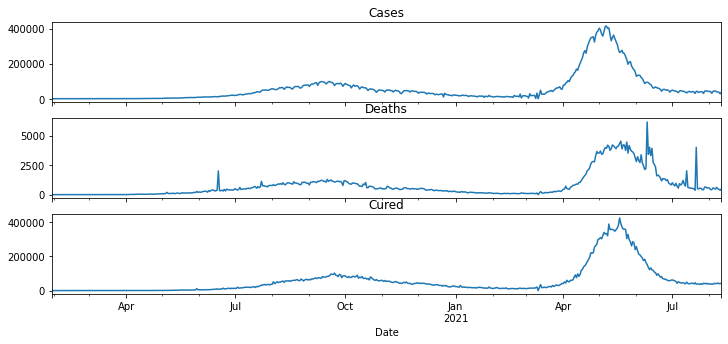

In [25]:
figure, axes = plt.subplots(3,sharex=True)
data['Cases'].plot(ax=axes[0],title='Cases',figsize=plotsize)
data['Deaths'].plot(ax=axes[1],title='Deaths',figsize=plotsize)
data['Cured'].plot(ax=axes[2],title='Cured',figsize=plotsize)

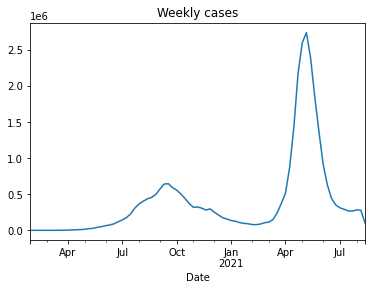

In [26]:
#Resampling number of cases by:Weekly data,Monthly data

cases_weekly = data['Cases'].resample('W').sum()
cases_weekly.plot(title='Weekly cases')

In [22]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [24]:
%matplotlib inline
plt.close('all')

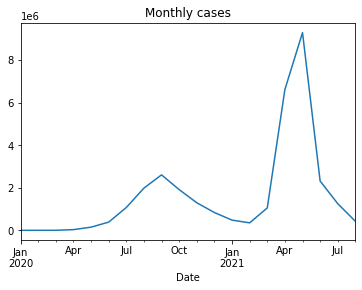

In [27]:
cases_monthly = data['Cases'].resample('M').sum()
cases_monthly.plot(title='Monthly cases')

In [28]:
#Setting up helper functions for forecasting
##get_n_last_days : Extract last n_days of a time series.
##plot_n_last_days : Plot last n_days of a time series

def get_n_last_days(df, series_name, n_days):

    return df[series_name][-(n_days):] 

def plot_n_last_days(df, series_name, n_days):

    plt.figure(figsize = (10,5))   
    plt.plot(get_n_last_days(df, series_name, n_days), 'k-')
    plt.title('{0} - {1} days'
              .format(series_name, n_days))
    plt.xlabel('Recorded day')
    plt.ylabel('Reading')
    plt.grid(alpha=0.3)

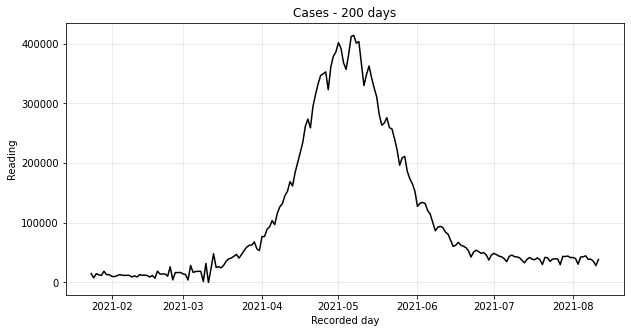

In [29]:
plot_n_last_days(data,'Cases',200)

In [30]:
def get_keras_format_series(series):

    series = np.array(series)
    return series.reshape(series.shape[0],series.shape[1],1)



def get_train_test_data(df, series_name, series_days, input_hours, 
                        test_hours, sample_gap=3):

    forecast_series = get_n_last_days(df, series_name, series_days).values # reducing our forecast series to last n days

    train = forecast_series[:-test_hours] # training data is remaining days until amount of test_hours
    test = forecast_series[-test_hours:] # test data is the remaining test_hours

    train_X, train_y = [], []

    # range 0 through # of train samples - input_hours by sample_gap. 
    # This is to create many samples with corresponding
    for i in range(0, train.shape[0]-input_hours, sample_gap): 
        train_X.append(train[i:i+input_hours]) # each training sample is of length input hours
        train_y.append(train[i+input_hours]) # each y is just the next step after training sample

    train_X = get_keras_format_series(train_X) # format our new training set to keras format
    train_y = np.array(train_y) # make sure y is an array to work properly with keras
    
    # The set that we had held out for testing (must be same length as original train input)
    test_X_init = test[:input_hours] 
    test_y = test[input_hours:] # test_y is remaining values from test set
    
    return train_X, test_X_init, train_y, test_y

In [31]:
series_days = 600
input_days = 5
test_days = 10

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(data, 'Cases', series_days, 
                         input_days, test_days))

In [32]:
print('Training input shape: {}'.format(train_X.shape))
print('Training output shape: {}'.format(train_y.shape))
print('Test input shape: {}'.format(test_X_init.shape))
print('Test output shape: {}'.format(test_y.shape))

Training input shape: (182, 5, 1)
Training output shape: (182,)
Test input shape: (5,)
Test output shape: (5,)


In [33]:
#defining LSTM model architecture

def fit_LSTM(X_train, y_train, epochs):
    
    # initialize model
    regressor = Sequential()

    # Adding the first LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = 45, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    regressor.add(Dropout(0.2))

    # Adding a second LSTM layer nd some Dropout regularisation
    regressor.add(LSTM(units = 45, return_sequences = True))
    regressor.add(Dropout(0.2))

    # Adding a third LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = 45, return_sequences = True))
    regressor.add(Dropout(0.2))

    # Adding a fourth LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = 45))
    regressor.add(Dropout(0.2))

    # Adding the output layer
    regressor.add(Dense(units = 1))
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    regressor.compile(loss='mean_squared_error', optimizer='adam')
    regressor.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=1)
    
    return regressor

In [34]:
model1 = fit_LSTM(train_X, train_y, epochs=1000)

Epoch 1/1000
3/3 [==============================] - 11s 18ms/step - loss: 10315960320.0000
Epoch 2/1000
3/3 [==============================] - 0s 15ms/step - loss: 10315944960.0000
Epoch 3/1000
3/3 [==============================] - 0s 19ms/step - loss: 10315921408.0000
Epoch 4/1000
3/3 [==============================] - 0s 17ms/step - loss: 10315882496.0000
Epoch 5/1000
3/3 [==============================] - 0s 16ms/step - loss: 10315821056.0000
Epoch 6/1000
3/3 [==============================] - 0s 17ms/step - loss: 10315726848.0000
Epoch 7/1000
3/3 [==============================] - 0s 15ms/step - loss: 10315596800.0000
Epoch 8/1000
3/3 [==============================] - 0s 16ms/step - loss: 10315461632.0000
Epoch 9/1000
3/3 [==============================] - 0s 16ms/step - loss: 10315319296.0000
Epoch 10/1000
3/3 [==============================] - 0s 16ms/step - loss: 10315206656.0000
Epoch 11/1000
3/3 [==============================] - 0s 16ms/step - loss: 10315117568.0000
Epoch 1

In [35]:
#making predictions

def mse(observations, estimates):

    # check arg types
    assert type(observations) == type(np.array([])), "'observations' must be a numpy array"
    assert type(estimates) == type(np.array([])), "'estimates' must be a numpy array"
    # check length of arrays equal
    assert len(observations) == len(estimates), "Arrays must be of equal length"
    
    # calculations
    difference = observations - estimates
    sq_diff = difference ** 2
    mse = sum(sq_diff)
    
    return mse

In [36]:
def predict(X_init, n_steps, model):

    
    X_init = X_init.copy().reshape(1,-1,1)
    preds = []
    
    # iteratively take current input sequence, generate next step pred,
    # and shift input sequence forward by a step (to end with latest pred).
    # collect preds as we go.
    for _ in range(n_steps):
        pred = model.predict(X_init)
        preds.append(pred)
        X_init[:,:-1,:] = X_init[:,1:,:]
        X_init[:,-1,:] = pred 
    
    preds = np.array(preds).reshape(-1,1)
    
    return preds

def predict_and_plot(X_init, y, model, title):

    y_preds = predict(test_X_init, n_steps=len(y), model=model) # predict through length of y
    # Below ranges are to set x-axes
    start_range = range(1, test_X_init.shape[0]+1) #starting at one through to length of test_X_init to plot X_init
    predict_range = range(test_X_init.shape[0], test_days)  #predict range is going to be from end of X_init to length of test_hours
    
    #using our ranges we plot X_init
    plt.plot(start_range, test_X_init)
    #and test and actual preds
    plt.plot(predict_range, test_y, color='orange')
    plt.plot(predict_range, y_preds, color='teal', linestyle='--')
    
    plt.title(title)
    plt.legend(['Initial Series','Target Series','Predictions'])
    print(y_preds)
    print("MSE:{}".format(np.mean(mse(y,y_preds))))

[[145.80775]
 [145.80775]
 [145.80775]
 [145.80775]
 [145.80775]]
MSE:6492871755.295631


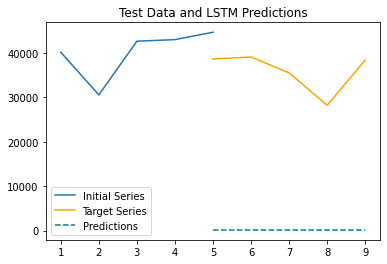

In [37]:
predict_and_plot(test_X_init, test_y, model1,
                 'Test Data and LSTM Predictions')

The deep learning model fails to learn due to small number of training instances.

**Decomposing the Time series.**
Any time series has 3 components associated with it:

1.Trend
2.Seasonality
3.Residual

In [38]:
#analysing number of cases

from statsmodels.tsa.seasonal import seasonal_decompose
data.drop(columns=['Cured','Deaths'],inplace=True)
data.columns = ['ds', 'y']
ss_decomposition = seasonal_decompose(x=data['y'], model='additive',freq=7)
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

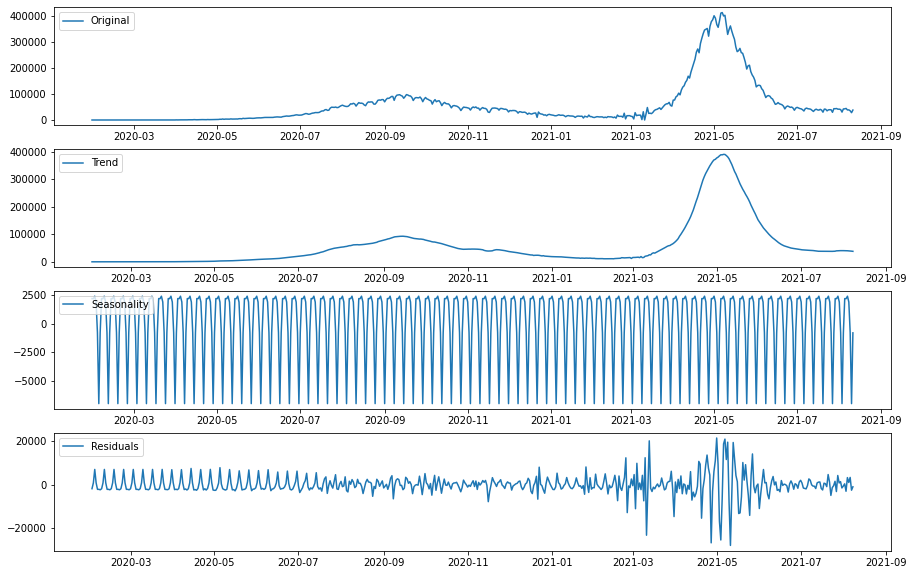

In [39]:
fig, axes = plt.subplots(4, 1)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(data['y'], label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual, label='Residuals')
axes[3].legend(loc='upper left');


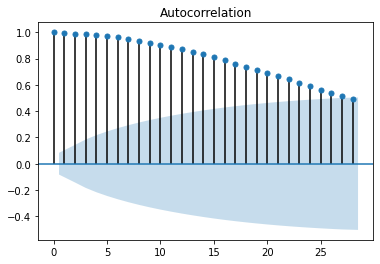

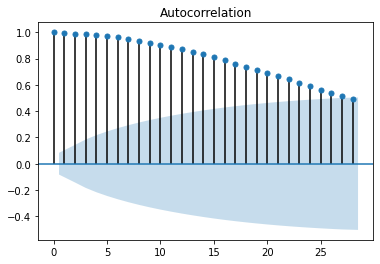

In [40]:
#plotting auto correlation function

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data['y'])

In [41]:
def run_sequence_plot(x, y, title, xlabel="time", ylabel="series"):
    plt.plot(x, y, 'k-')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.3);

In [42]:
#Dividing the dataset into chunks to analyze data in specific time periods

chunks = np.split(data['y'], indices_or_sections=7)
print("{} | {:7} | {}".format("Chunk", "Mean", "Variance"))
print("-" * 26)
for i, chunk in enumerate(chunks, 1):
    print("{:5} | {:.6} | {:.6}".format(i, np.mean(chunk), np.var(chunk)))

Chunk | Mean    | Variance
--------------------------
    1 | 184.887 | 1.1217e+05
    2 | 8810.91 | 4.13014e+07
    3 | 63736.3 | 4.45678e+08
    4 | 50819.1 | 2.60425e+08
    5 | 15910.3 | 3.01917e+07
    6 | 1.92165e+05 | 1.94989e+10
    7 | 68829.7 | 2.32563e+09


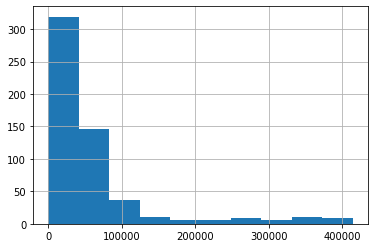

In [43]:
pd.Series(data['y']).hist();

Augmented Dickey Fuller test (ADF Test) is a common statistical test used to test whether a given Time series is stationary or not.

In [44]:
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(data['y'])

In [45]:
print("ADF:{}".format(adf))
print("Pvalue:{}".format(pvalue))

ADF:-3.1521311886760364
Pvalue:0.022928166916663627


p-value obtained is greater than significance level. Hence we cannot reject the null hypothesis. Therefore, We conclude the Time series is non-stationary.

In [46]:
print(estimated_residual)

Date
2020-01-30            NaN
2020-01-31            NaN
2020-02-01            NaN
2020-02-02   -1880.605083
2020-02-03     801.668358
                 ...     
2021-08-07   -2571.047736
2021-08-08   -1008.319368
2021-08-09            NaN
2021-08-10            NaN
2021-08-11            NaN
Name: y, Length: 560, dtype: float64


In [47]:
adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller(estimated_residual[3:-3])
print("ADF: ", adf_after)
print("p-value: ", pvalue_after)

ADF:  -4.121190001367937
p-value:  0.0008932948353245448


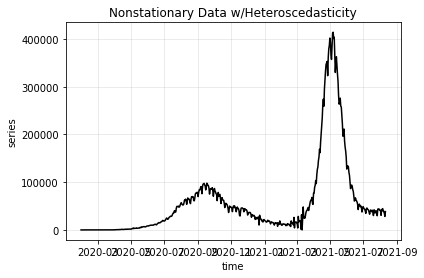

In [48]:
new_hetero = data['y'] + 38
run_sequence_plot(data.index, new_hetero,
                  title="Nonstationary Data w/Heteroscedasticity")

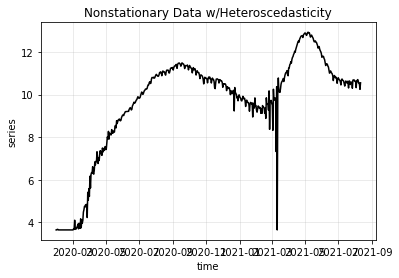

In [49]:
log_new_hetero = np.log(new_hetero)
run_sequence_plot(data.index, log_new_hetero,
                  title="Nonstationary Data w/Heteroscedasticity")

In [50]:
df_diff = data['y'].diff()
df_diff

Date
2020-01-30        NaN
2020-01-31        0.0
2020-02-01        1.0
2020-02-02        0.0
2020-02-03       -1.0
               ...   
2021-08-07    -6015.0
2021-08-08      442.0
2021-08-09    -3571.0
2021-08-10    -7295.0
2021-08-11    10149.0
Name: y, Length: 560, dtype: float64

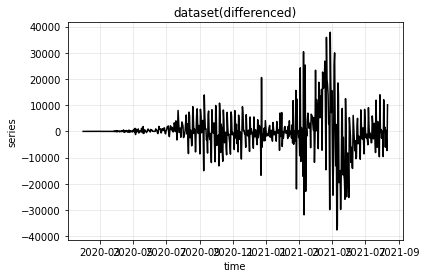

In [51]:
run_sequence_plot(data.index,df_diff,
                  title="dataset(differenced)")

In [52]:
#Dividing Time series into Train and test for predictions.
#for 30 days

train = np.array(data['y'][1:-30])
test = np.array(data['y'][-30:])

In [53]:
from statsmodels.tsa.api import SimpleExpSmoothing

single = SimpleExpSmoothing(train).fit(optimized=True)
single_preds = single.forecast(len(test))
single_mse = mse(test, single_preds)
print("Predictions: ", single_preds)
print("MSE: ", single_mse)

Predictions:  [37154. 37154. 37154. 37154. 37154. 37154. 37154. 37154. 37154. 37154.
 37154. 37154. 37154. 37154. 37154. 37154. 37154. 37154. 37154. 37154.
 37154. 37154. 37154. 37154. 37154. 37154. 37154. 37154. 37154. 37154.]
MSE:  666613289.0


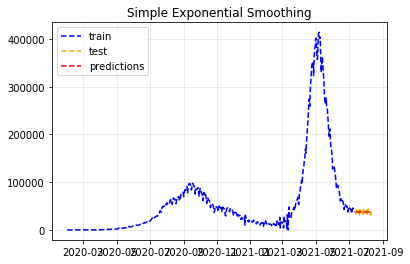

In [54]:
plt.plot(data.index[1:-30], train, 'b--', label="train")
plt.plot(data.index[-30:], test, color='orange', linestyle="--", label="test")
plt.plot(data.index[-30:], single_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Simple Exponential Smoothing")
plt.grid(alpha=0.3);

In [55]:
from statsmodels.tsa.api import Holt

double = Holt(train).fit(optimized=True)
double_preds = double.forecast(len(test))
double_mse = mse(test, double_preds)
print("Predictions: ", double_preds)
print("MSE: ", double_mse)

Predictions:  [36657.92295069 35611.59275246 34565.26255423 33518.932356
 32472.60215777 31426.27195954 30379.94176131 29333.61156308
 28287.28136485 27240.95116662 26194.62096839 25148.29077016
 24101.96057193 23055.6303737  22009.30017547 20962.96997724
 19916.63977901 18870.30958078 17823.97938255 16777.64918432
 15731.31898609 14684.98878786 13638.65858963 12592.3283914
 11545.99819317 10499.66799494  9453.33779671  8407.00759848
  7360.67740025  6314.34720202]
MSE:  12008988076.3507


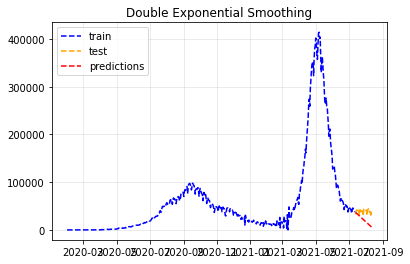

In [56]:
plt.plot(data.index[1:-30], train, 'b--', label="train")
plt.plot(data.index[-30:], test, color='orange', linestyle="--", label="test")
plt.plot(data.index[-30:], double_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Double Exponential Smoothing")
plt.grid(alpha=0.3);

In [57]:
from statsmodels.tsa.api import ExponentialSmoothing

triple = ExponentialSmoothing(train,
                              trend="additive",
                              seasonal="additive",
                              seasonal_periods=13).fit(optimized=True)
triple_preds = triple.forecast(len(test))
triple_mse = mse(test, triple_preds)
print("Predictions: ", triple_preds)
print("MSE: ", triple_mse)

Predictions:  [36818.14107344 35296.98143956 33649.87614835 33224.66472858
 32465.80779528 32083.5782581  29972.46263662 28472.39873434
 28358.73709824 26269.71721933 26204.66619508 25244.73811408
 23940.11664071 23075.2001873  21554.04055342 19906.93526221
 19481.72384244 18722.86690914 18340.63737196 16229.52175048
 14729.4578482  14615.7962121  12526.77633319 12461.72530894
 11501.79722794 10197.17575457  9332.25930116  7811.09966728
  6163.99437607  5738.7829563 ]
MSE:  12416021629.606508


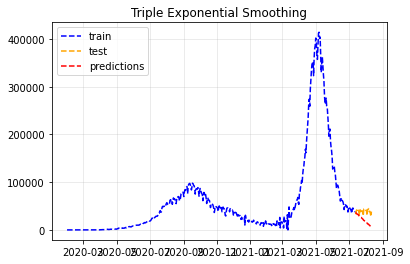

In [58]:
plt.plot(data.index[1:-30], train, 'b--', label="train")
plt.plot(data.index[-30:], test, color='orange', linestyle="--", label="test")
plt.plot(data.index[-30:], triple_preds, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title("Triple Exponential Smoothing")
plt.grid(alpha=0.3);

In [59]:
#comaprng the result of three statistical models

print("Single MSE :{}".format(single_mse))
print("Double MSE :{}".format(double_mse))
print("Triple MSE :{}".format(triple_mse))


Single MSE :666613289.0
Double MSE :12008988076.3507
Triple MSE :12416021629.606508
